In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder


#train and test data directory
data_dir = "/home/usd.local/neerajdattu.dudam/rizk_lab/shared/neerajdattu/dataset/Training"
test_data_dir = "/home/usd.local/neerajdattu.dudam/rizk_lab/shared/neerajdattu/dataset/Testing"


#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [2]:
img, label = dataset[0]
print(img.shape,label)


torch.Size([3, 150, 150]) 0


In [3]:
print("Follwing classes are there : \n",dataset.classes)


Follwing classes are there : 
 ['glioma', 'meningioma', 'notumor', 'pituitary']


Label : glioma


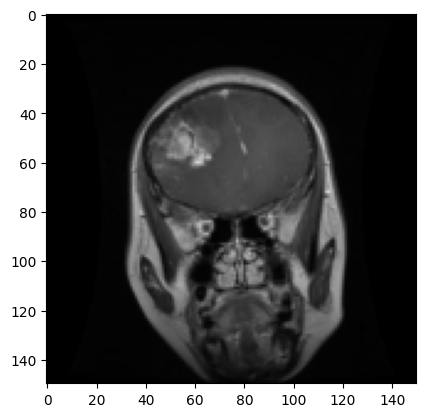

In [4]:
import matplotlib.pyplot as plt

def display_img(img, label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1, 2, 0))

#display the first image in the dataset
display_img(*dataset[0])

In [5]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128

print(f"Length of Train Data : {len(dataset)}")
print(f"Length of test Data : {len(test_dataset)}")


#load the train and test into batches.
train_dl = DataLoader(dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 5712
Length of test Data : 1311


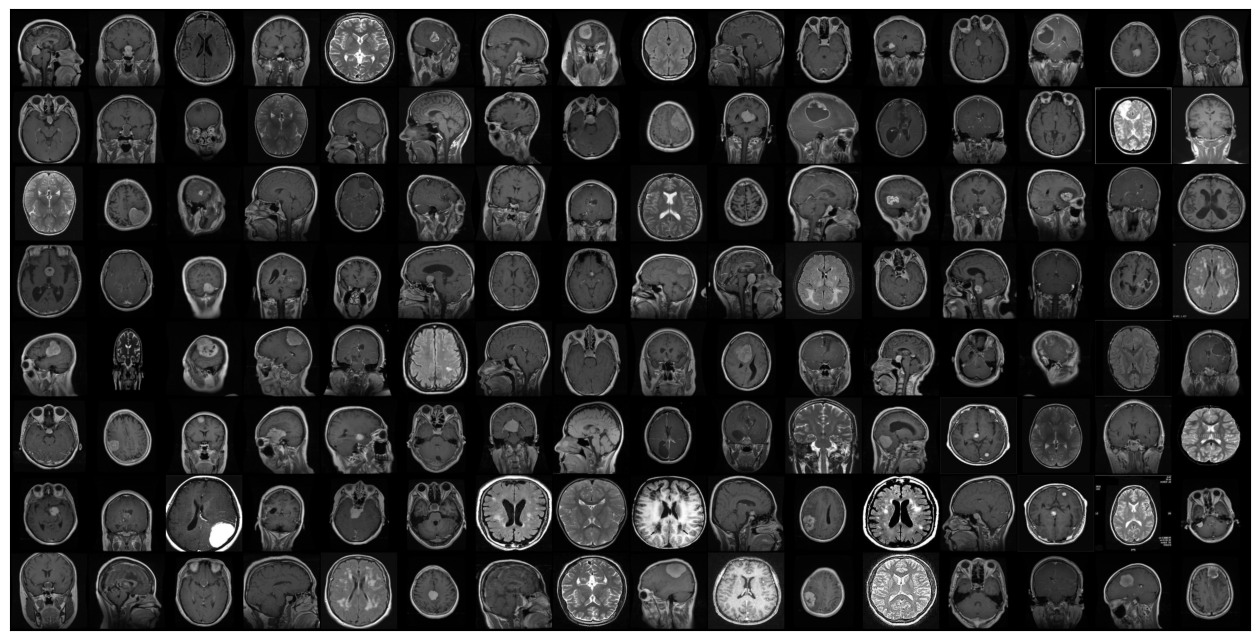

In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [11]:
from torchvision.models import vgg16

import torch.nn as nn
import torch.optim as optim

# Load the pre-trained VGG16 model
model = vgg16(pretrained=True)

# Modify the classifier to match the number of classes in the dataset
num_classes = len(dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_dl, test_dl, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_accuracy = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        test_loss, test_accuracy = test_model(model, test_dl, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return train_losses, train_accuracies, test_losses, test_accuracies

# Testing loop
def test_model(model, test_dl, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_dl.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

# Train the model
train_losses, train_accuracies, test_losses, test_accuracies = train_model(model, train_dl, test_dl, criterion, optimizer, num_epochs=30)

Epoch 1/30, Train Loss: 1.4380, Train Accuracy: 0.2658, Test Loss: 4.6832, Test Accuracy: 0.2288
Epoch 2/30, Train Loss: 1.4225, Train Accuracy: 0.2871, Test Loss: 1.2454, Test Accuracy: 0.4523
Epoch 3/30, Train Loss: 1.3623, Train Accuracy: 0.3104, Test Loss: 1.4322, Test Accuracy: 0.3730
Epoch 4/30, Train Loss: 1.3958, Train Accuracy: 0.2974, Test Loss: 1.3122, Test Accuracy: 0.3898
Epoch 5/30, Train Loss: 1.3060, Train Accuracy: 0.3732, Test Loss: 1.2552, Test Accuracy: 0.3692
Epoch 6/30, Train Loss: 1.0352, Train Accuracy: 0.5070, Test Loss: 1.0415, Test Accuracy: 0.5202
Epoch 7/30, Train Loss: 0.7650, Train Accuracy: 0.6551, Test Loss: 0.8755, Test Accuracy: 0.6392
Epoch 8/30, Train Loss: 0.6264, Train Accuracy: 0.7467, Test Loss: 0.7874, Test Accuracy: 0.6735
Epoch 9/30, Train Loss: 0.4897, Train Accuracy: 0.8051, Test Loss: 0.6020, Test Accuracy: 0.7613
Epoch 10/30, Train Loss: 0.4575, Train Accuracy: 0.8167, Test Loss: 0.6088, Test Accuracy: 0.7536
Epoch 11/30, Train Loss: 0.43

In [12]:
import pickle

# Save the model
with open('vgg16_model.pkl', 'wb') as f:
    pickle.dump(model.state_dict(), f)

# Save the training and testing metrics
metrics = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'test_losses': test_losses,
    'test_accuracies': test_accuracies
}

with open('training_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

print("Model and metrics saved successfully.")

Model and metrics saved successfully.


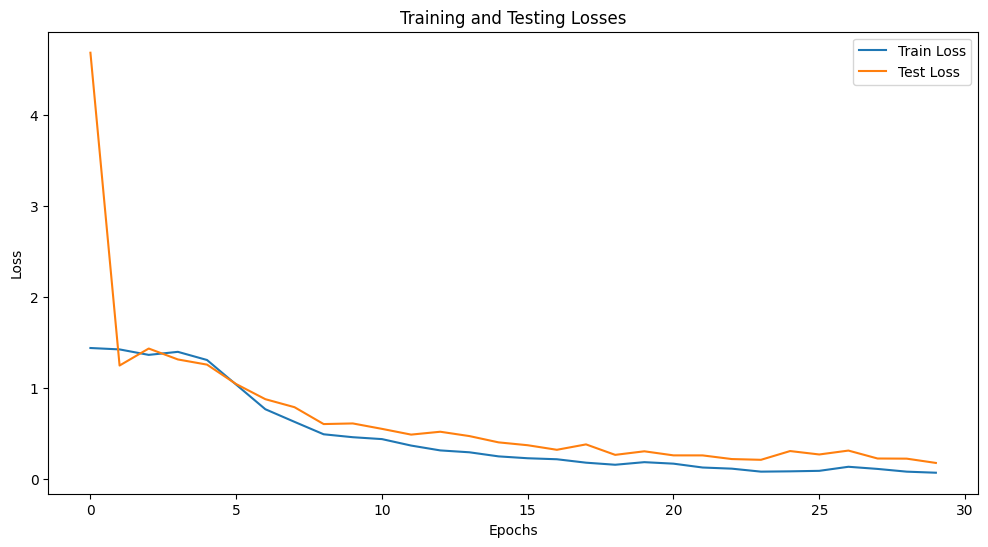

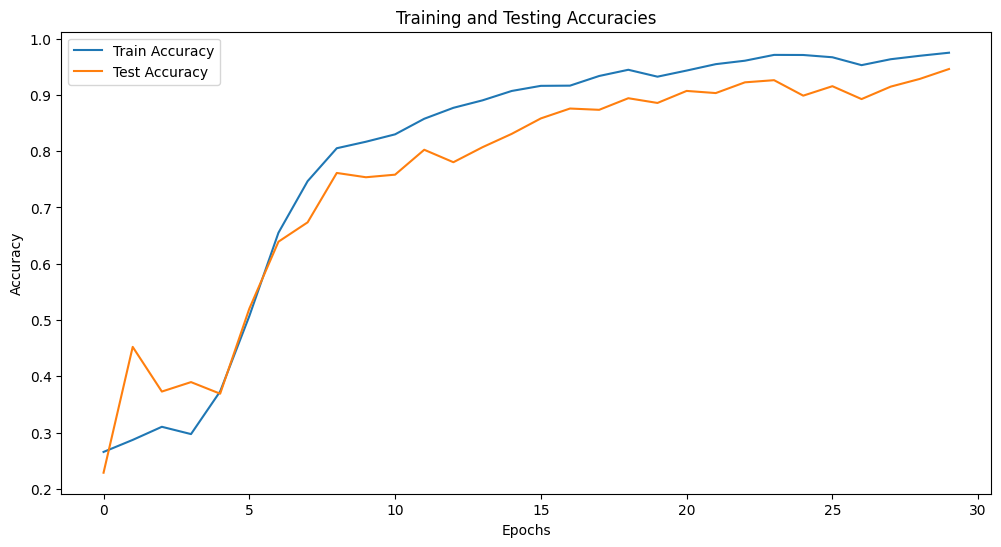

In [13]:
import matplotlib.pyplot as plt

# Plot training and testing losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.show()

# Plot training and testing accuracies
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies')
plt.legend()
plt.show()

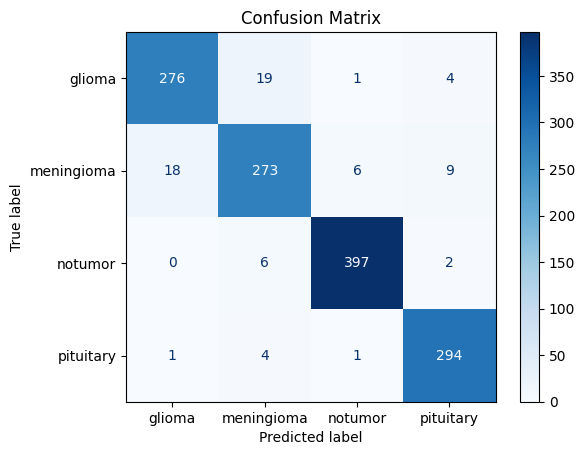

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Function to test the model and get predictions
def get_predictions(model, test_dl):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# Get the true labels and predictions
true_labels, predictions = get_predictions(model, test_dl)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()